<a href="https://colab.research.google.com/github/phyop/220505_TensorFlow2/blob/main/220329_TFRecords%E4%BD%BF%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## TFRecords制作

为了高效地读取数据，可以将数据进行序列化存储，这样也便于网络流式读取数据。TFRecord是一种比较常用的存储二进制序列数据的方法

- tf.Example类是一种将数据表示为{"string": value}形式的meassage类型，Tensorflow经常使用tf.Example来写入、读取TFRecord数据

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf

### 通常情况下，tf.Example中可以使用以下几种格式：

- tf.train.BytesList: 可以使用的类型包括 string和byte
- tf.train.FloatList: 可以使用的类型包括 float和double
- tf.train.Int64List: 可以使用的类型包括 enum,bool, int32, uint32, int64

转化实例

In [ ]:
# _float_feature() 之類的方法，是爲了給內部的 "def image_example()" 使用的
# 把資料轉型成 tf.train.Example 需要的格式
# 不是給外部呼叫，所以用底線開頭的私有方法
# https://www.tensorflow.org/tutorials/load_data/tfrecord
# 反正就是TF定義的標準API，幫忙user構建數據集，
# 所以user有數據，往這個東西裏面套用就對了，不用研究的太過深入。
def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))): # 如果傳入的value是EagerTensor子類的話，就轉換成numpy的形式
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.（如果value是字串的話，就不轉）
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Return a float_list form a float/double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Return a int64_list from a bool/enum/int/uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
tf.constant(0) # <tf.Tensor: shape=(), dtype=int32, numpy=0>
type(tf.constant(0)) # tensorflow.python.framework.ops.EagerTensor

tensorflow.python.framework.ops.EagerTensor

In [ ]:
# feature轉換實例

## 呼叫函數_bytes_feature，會返回一個類似字典的結構
## 告訴我們裏面裝的類型是bytes_list，包含了值"test_string"
print(_bytes_feature(b'test_string'))
print(_bytes_feature('test_string'.encode('utf8')))
# print(_bytes_feature(3)) # 3 has type int, but expected one of: bytes
# print(type(_bytes_feature(b'test_string'))) # <class 'tensorflow.core.example.feature_pb2.Feature'>

## 呼叫函數_float_feature，會返回一個類似字典的結構
## 告訴我們裏面裝的類型是float_list，包含了值2.7182817459106445
print(_float_feature(np.exp(1)))

## 呼叫函數_int64_feature，會返回一個類似字典的結構
## 告訴我們裏面裝的類型是int64_list，包含了值1
## bool類型也可以算在int64_feature裏面
print(_int64_feature(True)) 
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_string"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



### tfrecord制作方法

创建tf.Example

In [ ]:
## 輸入圖像，不止有像素點而已，還可能會有各種訊息，比如長寬高、拍攝地點、日期等不同格式
## 這時候特徵就不會至於單一種類型而已，所以才會不止有feature0，還有feature1～3
def serialize_example(feature0, feature1, feature2, feature3):
    """
    创建tf.Example
    """
    
    # 轉什麼類型還是要自己決定
    feature = {
        'feature0': _int64_feature(feature0), # 把feature0轉成int64的格式
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2), # 把feature2轉成bytes的格式
        'feature3': _float_feature(feature3), # 把feature2轉成float的格式
    }
    #使用tf.train.Example来创建
    # 引數代表當您呼叫程式時，您傳遞給程式參數的值
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature)) # 第1個feature是Features的參數，第2個feature是引數（也就是轉換完的結果）
    # 上面的code，代表轉換完一條數據了
    #SerializeToString方法转换为二进制字符串
    return example_proto.SerializeToString() # 通常情況下，都會把結果轉成序列再做返回

In [ ]:
# 数据量
n_observations = int(1e4)

# Boolean feature
feature0 = np.random.choice([False, True], n_observations)

# Integer feature
feature1 = np.random.randint(0, 5, n_observations) # [4 4 0 ... 0 2 2]

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat']) # [b'cat' b'dog' b'chicken' b'horse' b'goat']
# numpy.ndarray1[numpy.ndarray2] -> 用array2當index，去取array1中的值
# 所以這樣feature0～3,就都會是n_observations的長度了
feature2 = strings[feature1] # [b'goat' b'goat' b'cat' ... b'cat' b'chicken' b'chicken']

# Float feature
feature3 = np.random.randn(n_observations)

In [ ]:
filename = 'tfrecord-1' # 要存成h5格式的名字

with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_observations): # 遍歷n條數據
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i]) # 轉換一條數據成tf.train.Example的格式
        writer.write(example) # 將轉換好的數據寫入 filename.h5

### 加载tfrecord文件

In [ ]:
filenames = [filename]

# https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset
# TFRecordDataset([example_path])，因爲可以有一個或多個文件名，所以路徑會是一個list
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

### 图像数据处理实例

In [ ]:
import os
import glob
from datetime import datetime

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

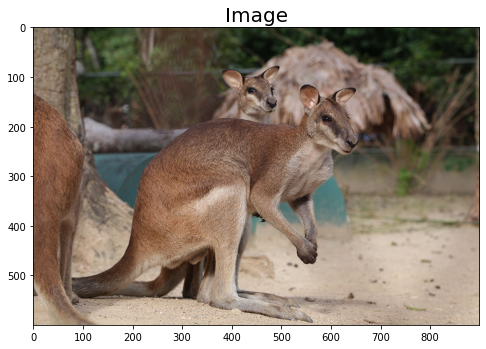

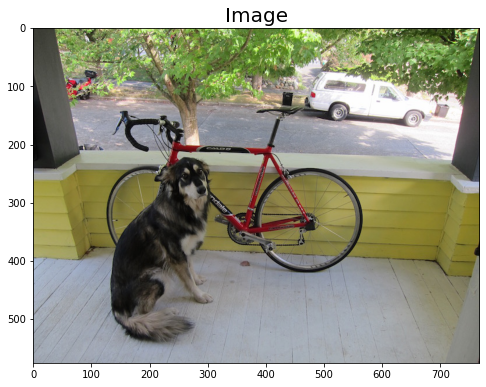

In [ ]:
image_path = '/content/drive/MyDrive/GoogleDrive_yaboaru/Colab Notebooks/220304_唐tensorflow2版本实战/TFRecord/img/'
# path有加沒加/有差哦！
images = glob.glob(image_path + '*.jpg') # glob.glob(path1 + path2)就是適合做unix的資料名稱正則搜尋

# https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.imread.html#matplotlib-pyplot-imread
# 由於歷史原因而存在matplotlib.pyplot.imread，建議使用PIL.Image.open
# https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=pyplot%20subplots#matplotlib.pyplot.subplots
# fig, axs = plt.subplots(2, 2) # 不解包的話，可以這樣呼叫 "axs[0, 0].plot(x, y)"
# fig, (ax1, ax2) = plt.subplots(1, 2) # 可以用元組來解包成自己需要的形態
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
for fname in images:
    image = mpimg.imread(fname) 
    # 每次都for都會讀到一張image
    # 而如果寫plt.subplots(1, 2)， 那每次的for，都會做出2張子圖
    # 所以2張子圖，但只有對到一張圖，範圍對不上就會報錯
    # 除非連帶的把改ax1.改成ax1[0].，比如ax1[0].imshow(image)、ax1.set_title('Image', fontsize=20)
    # 指定要把那張唯一的image設置到ax1[0]的子圖，讓ax1[1]是一張空白子圖
    f, ax1 = plt.subplots(1, 1, figsize=(8,8)) # 因為只有一個圖，所以解不解包都可以
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(image)
    ax1.set_title('Image', fontsize=20)

In [ ]:
image_labels = {
    'dog': 0,
    'kangaroo': 1,
}

### 制作TFRecord

In [ ]:
# 流程：讀數據，轉成相對應的feature格式，序列化到example格式，存檔成h5文件
# 读数据，binary格式

"""
test.txt 的内容如下：
RUNOOB1
RUNOOB2

>>> f = open('test.txt')
>>> f.read()
'RUNOOB1\nRUNOOB2\n'
"""

dog_image = image_path + 'dog.jpg' # 如果用glob.glob(image_path + 'dog.jpg')，回傳的是list，list中裝的是各個符合正則搜尋的path字串
image_string = open(dog_image, 'rb').read()
print(image_string)
label = image_labels['dog'] # image_labels是dict，所以會回傳dog這個key的value值0

b'\xff\xd8\xff\xe1\x02\xe6Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x0e\x00\x02\x00\x00\x00 \x00\x00\x00\x86\x01\x0f\x00\x02\x00\x00\x00\x06\x00\x00\x00\xa6\x01\x10\x00\x02\x00\x00\x00\x14\x00\x00\x00\xac\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\xc0\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xc8\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x011\x00\x02\x00\x00\x00\x0b\x00\x00\x00\xd0\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xdc\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xf0\x00\x00\x00\x00                               \x00Canon\x00Canon PowerShot S95\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01Photos 1.0\x00\x002014:09:19 16:08:30\x00\x00\x1e\x82\x9a\x00\x05\x00\x00\x00\x01\x00\x00\x02^\x82\x9d\x00\x05\x00\x00\x00\x01\x00\x00\x02f\x88\'\x00\x03\x00\x00\x00\x01\x00\xfa\x00\x00\x880\x00\x03\x00\x00\x00\x01\x00\x04\x00\x00\x90\x00\x00\x07\x00\x00\x00\x040230\x90\x03\x00\x02\x00\x00\x00\x14\x00\x00\x02n\x90\x04\x00\x02

In [ ]:
# 這3個函數和上面寫得都一樣，只是copy過來而已
def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Return a float_list form a float/double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Return a int64_list from a bool/enum/int/uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 创建图像数据的Example
def image_example(image_string, label): # image_string就是圖片的一長串2進位檔
    image_shape = tf.image.decode_jpeg(image_string).shape # (576, 768, 3)，將2進位的圖片decode成(長， 寬， channel)張量

    # 因為image_string是2進制檔案，所以要先轉成我們看得懂格式，也就是(576, 768, 3)，才有辦法去處理特征
    feature = { # 各種圖像的訊息都轉成train.Features格式，然後以字典方式包起來，送給train.Example
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label), # 分類的標籤，當然也是圖像的特征之一
        'image_raw': _bytes_feature(image_string), # 其他周邊都有了，但唯獨沒有像素資料，搞屁對吧？所以像素值當然是特征
        # 原數據image_string是2進制檔案，所以轉成bytes
    }

    return tf.train.Example(features=tf.train.Features(feature=feature)) # 有了各項特征之後，就可以包在一起，存成Example格式了

In [ ]:
#打印部分信息
image_example_proto = image_example(image_string, label) # 回傳tf.train.Example的物件

for line in str(image_example_proto).split('\n')[:15]: # 看一下Example物件裡面是什麼
    print(line) # Example -> features{feature字典1, ..., feature字典n}  
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 576
      }
...


In [ ]:
# 制作 `images.tfrecords`.

image_path = './img/'
images = glob.glob(image_path + '*.jpg')
record_file = 'images.tfrecord'
counter = 0

# 在TFRecordWriter中，對每一張圖像以2進位去打開，連同標籤制作成train.Example格式
# 然後將Example做序列化，以io.TFRecordWriter寫入tfrecord檔
with tf.io.TFRecordWriter(record_file) as writer: # 取名writer是因為前面是writer；取名盡量前後直覺聯想最好
    for fname in images: 
        with open(fname, 'rb') as f:
            image_string = f.read() # 2進位或txt都是用read()，圖像的話可以用PIL
            label = image_labels[os.path.basename(fname).replace('.jpg', '')] # 去除目錄的路徑，回傳檔案名稱，然後再把附檔名取代掉
            
            # `tf.Example` 
            tf_example = image_example(image_string, label) # 輸入2進位圖像與標籤，制作成train.Example格式
            
            # 将`tf.example` 写入 TFRecord 
            writer.write(tf_example.SerializeToString()) # 再將train.Example格式做序列化，以io.TFRecordWriter寫入.tfrecord檔
            
            counter += 1 # 沒做完一張圖就+1
            print('Processed {:d} of {:d} images.'.format( # print('...{}...{}...'.format(xx, xx))
                counter, len(images)))

print(' Wrote {} images to {}'.format(counter, record_file)) # 寫到哪個.tfrecord檔案

 Wrote 0 images to images.tfrecord


### 加载制作好的TFRecord

In [ ]:
raw_train_dataset = tf.data.TFRecordDataset('images.tfrecord') # 以TFRecordDataset去讀取.tfrecord檔。因爲是以序列化儲存，所以回傳的是tf.string
raw_train_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

example数据都进行了序列化，还需要解析以下之前写入的序列化string
- tf.io.parse_single_example(example_proto, feature_description)函数可以解析单条example

In [ ]:
# 要從train.Example讀取數據，轉回圖像，那就是反序列化，或稱為解析，也就是parse
# 把解析的對照關係指定給到tf.io.parse_single_example(serialized, features)的參數features（就是唐寫的feature_description）
# 會回傳單條train.Example中的字典映射關係
# tf.io.FixedLenFeature中，原本是int64就轉回tf.int64，原本是string就轉回tf.string
# https://www.tensorflow.org/api_docs/python/tf/io/parse_single_example
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

现在看起来仅仅完成了一个样本的解析，实际数据不可能一个个来写吧，可以定义一个映射规则map函数

In [ ]:
# 解析序列化後的train.Example，以key-value方式分別取出(data, lable)
# 將data做decode_jpeg，轉成可訓練的張量型式(長， 寬， channel)
# 要做訓練前，data要做歸一化：resize成大小相同的圖片、數值0~1、均值0、標準差1之類的
# 以dataset.map(自定義func)方式，將dataset中所有序列化資料，都一一送去執行自定義func
def parse_tf_example(example_proto):
    # 把一條(一張圖片)train.Example的序列化映射關係，解析出來
    # parse_single_example(serialized, features)
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # 预处理
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3) # image.decode_jpeg會將2進位的圖片decode成張量(長， 寬， channel)
    x_train = tf.image.resize(x_train, (416, 416)) # 把原本不定長的圖像，resize成同大小的張量，去做conv、特征圖疊加時，才合得起來。不然中間位置每張圖都有貢獻，但邊緣位置，只有部分大圖才有貢獻到
    x_train /= 255. # 訓練資料最好都歸一化成數值0~1、均值0、標準差1之類的

    lebel = parsed_example['label'] # parse_single_example會回傳單條train.Example中的字典映射關係，所以就可以利用key去找value
    y_train = lebel 
    
    return x_train, y_train

# 《儲存成TFRecords》 feature -> Example -> 序列化tf.string
# 《轉回圖像與標籤》 
# parse結果 = parse_single_example(序列化tf.string, features) 
# 一一取出序列化的圖片(tf.string)，做parse，將結果處理成原圖像和標籤，指派給變數(x_train, y_train)
# (image.decode_jpeg(parse結果['圖像raw檔的feature'], parse結果['標籤']) -> (data, lable)
train_dataset = raw_train_dataset.map(parse_tf_example) # 一一取出dataset的元素當引數，丟去map裡的函數parse_tf_example
train_dataset

<MapDataset element_spec=(TensorSpec(shape=(416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### 制作训练集

In [ ]:
# shuffle(buffer_size)從該緩衝區中隨機採樣元素，用新元素替換選定的元素。對於完美的混洗，需要大於或等於數據集完整大小的緩衝區大小
# 例如，如果您的數據集包含 10,000 個元素但buffer_size設置為 1,000
# 則shuffle最初將僅從緩衝區中的前 1,000 個元素中選擇一個隨機元素
# 一旦選擇了一個元素，它在緩衝區中的空間將被下一個（即第 1,001 個）元素替換，從而保持 1,000 個元素的緩衝區
# 做了batch之後，每1次的迭代中會包含2個元素
# https://www.tensorflow.org/api_docs/python/tf/repeat
# tf.repeat(輸入，每個元素的重複次數)
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat
# dataset.repeat(資料集重複次數)
num_epochs = 10
train_ds = train_dataset.shuffle(buffer_size=10000).batch(2).repeat(num_epochs)
train_ds # <RepeatDataset shapes: ((None, 416, 416, 3), (None,)), types: (tf.float32, tf.int64)>
# 數組np.ndarray的形狀是(batch_size, *target_size, channels)
# 因爲1個batch有2張圖，而1個epoch只有1個batch，所以對epoch來說，等於就是沒有分批訓練的意思，那batch的值就是None

<RepeatDataset element_spec=(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# 因爲使用enumerate，所以這邊的batch其實不是batch的原意，那些0～9只是單純的依序數值
# 因爲train_dataset被repeat了10次，所以train_ds可以取出10組，也就是enumerate的0～9
# 所以如果可以print出來的話，會印出10次的 "(2, 416, 416, 3) tf.Tensor(...)"
for batch, (x, y) in enumerate(train_ds): # ds -> dataset
    print(batch, x.shape, y)

In [ ]:
# 要做歸一化分類就用dense搭配softmax函數，因爲分2類，所以就2個神經元
# 做dense前要flatten拉平
# 這個model沒有中間隱層
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# 因爲要分類，所以loss func可以用SparseCategori
# 因爲是有標準答案的分類，所以評量模型好壞就用準確率
# compile就是去設置model的各種參數，而model則是模型的網路架構
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# 所謂的跑訓練，就是去以降低loss爲目標，反向傳導計算權重參數的調整值，並列印出來loss和評核量值的結果
model.fit(train_ds, epochs=num_epochs)

Epoch 1/10
10/10 [==============================] - 1s 51ms/step - loss: 55.1923 - accuracy: 0.6500
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0000

In [ ]:
"""

《EagerTensor》
https://zhuanlan.zhihu.com/p/74441082

Eager这个东西是为了支持function一类的操作，不再用以前那种类似Session引入的。

在动态图下创建的张量是EagerTensor（引用方式为from tensorflow.python.framework.ops import EagerTensor），
在静态图下创建的张量是tf.Tensor。
EagerTensor和tf.Tensor虽然非常相似，但是不完全一样，
如果依赖于EagerTensor特有的一些方法，会导致转换到静态图时tf.Tensor没有这些方法而报错。


.numpy()方法是EagerTensor所特有的，tf.Tensor并没有，
这个方法非常好的地方在于可以将一个EagerTensor转换成一个numpy.array，适合于调试和验证时使用，
如果在转换中也使用了这个方法，会直接报tf.Tensor没有这个属性的错误（AttributeError）。
一般使用EagerTensor.numpy()会有两种情况：

（1）找不到合适的TensorFlowOp来表达运算，而想用numpy的函数，使用tf.numpy_function

必须承认是的TensorFlow的存在的这么多（len(dir(tf.raw_ops))个）的Op依然不足以完全覆盖numpy所有的功能，因此在一些情况下找不到合适的Op（或者Op组合）表达运算逻辑时，能用上numpy的函数也是挺好的，因此可能会有人会想到先EagerTensor转换成numpy然后用numpy运算完再转换成Tensor……tf.function可不允许这么做，还是老老实实用tf.numpy_function吧。

（2）希望打印看看运算结果，使用tf.print(tensor)而非print(tensor.numpy())

使用tf.print(tensor)能够无论在动态图还是静态图下都能够打印出张量的内容，
而print(tensor.numpy())只能在动态图下使用。


EagerTensor是可以被遍历的，
但是tf.Tensor不行，尽量使用向量化的操作。


tf.function直接装饰一个python函数会得到一个静态图执行的def_function.Function，用于速度的提升和部署。


"""
##########################################################
"""
《靜態圖 vs 動態圖》
https://blog.51cto.com/u_15274944/2921874


目前神经网络框架分为静态图框架和动态图框架，
PyTorch 和 TensorFlow、Caffe 等框架最大的区别就是他们拥有不同的计算图表现形式。 TensorFlow使用静态图，这意味着我们先定义计算图，然后不断使用它，
而在PyTorch中，每次都会重新构建一个新的计算图。

动态计算意味着程序将按照我们编写命令的顺序进行执行。 
这种机制将使得调试更加容易，并且也使得我们将大脑中的想法转化为实际代码变得更加容易。
而静态计算则意味着程序在编译执行时，将先生成神经网络的结构，然后再执行相应操作。 
静态计算是通过先定义后运行的方式，之后再次运行的时候就不再需要重新构建计算图，所以速度会比动态图更快。
从理论上讲，静态计算这样的机制允许编译器进行更大程度的优化，但是这也意味着你所期望的程序与编译器实际执行之间存在着更多的代沟。

就像Python是直譯語言，邊編譯邊執行，直到遇錯就停止並回報，比較符合人類直覺；
而c和java都需要先經過編譯，確定整體基本無誤之後，才能再去執行編譯檔，找更高階的錯誤。
所以pytorch這樣的動態圖，就像Python一樣直覺簡單；
而TF則像是C，不接近人類語言，但做執行多次的情況下，可以節省掉一大段耗費編譯資源的轉換時間。

这也意味着，代码中的错误将更加难以发现。
比如，如果计算图的结构出现问题，你可能只有在代码执行到相应操作的时候才能发现它。

TensorFlow需要将整个图构建成静态的，换句话说，每次运行的时候图都是一样的，是不能够改变的，
所以不能直接使用Python 的 while 循环语句，
需要使用辅助函数tf.while_loop写成 TensorFlow 内部的形式.


https://juejin.cn/post/6863801888144850958


计算图是用来描述运算的有向无环图
计算图有两个主要元素：结点（Node）和边（Edge）；
结点表示数据 ，如向量、矩阵、张量;
边表示运算 ，如加减乘除卷积等；


y=(x+w)∗(w+1)y=(x+w)∗(w+1)
其中呢，a=x+wa=x+w ，b=w+1b=w+1 , y=a∗by=a∗b. (a和b是类似于中间变量的那种感觉。)

叶子节点，是w和x，是整个计算图的根基。
叶子节点的概念，是为了减少内存，在反向传播结束之后，非叶子节点的梯度会被释放掉。
可以通过.retain_grad()来保留非任意节点的梯度值。

import torch
w = torch.tensor([1.],requires_grad = True)
x = torch.tensor([2.],requires_grad = True)

a = w+x
a.retain_grad()
b = w+1
y = a*b

y.backward()
print(w.is_leaf,x.is_leaf,a.is_leaf,b.is_leaf,y.is_leaf) 
# True True False False False
print(w.grad,x.grad,a.grad,b.grad,y.grad)
# tensor([5. ]) tensor([2. ]) tensor([2. ]) None None


动态图：pytorch使用的，运算与搭建同时进行；灵活，易调节。
静态图：老tensorflow使用的，先搭建图，后运算；高效，不灵活。


静态图我们是需要先定义好运算规则流程的。比方说，我们先给出
a=x+wa = x+wa=x+w , b=w+1b=w+1b=w+1 , y=a×by=a\times by=a×b
然后把上面的运算流程存储下来，然后把w=1，x=2放到上面运算框架的入口位置进行运算。
Tensorflow构建运算的时候，先构建运算框架，然后再把具体的数字放入其中。
整个过程类似于训练神经网络，我们要构建好模型的结构，然后再训练的时候再吧数据放到模型里面去。
又类似于在旅游的时候，我们事先定要每天的行程路线，然后每天按照路线去行动。


动态图是直接对着已经赋值的w和x进行运算，然后变运算变构建运算图。
就是直接对数据进行运算，然后动态的构建出运算图。很符合我们的运算习惯。


两者的区别在于，静态图先说明数据要怎么计算，然后再放入数据。
假设要放入50组数据，运算图因为是事先构建的，所以每一次计算梯度都很快、高效。


动态图的运算图是在数据计算的同时构建的，
假设要放入50组数据，那么就要生成50次运算图。
这样就没有那么高效。所以称为动态图。


动态图虽然没有那么高效，但是他的优点有以下：
更容易调试。
动态计算更适用于自然语言处理。（这个可能是因为自然语言处理的输入往往不定长？）
动态图更面向对象编程，我们会感觉更加自然。


"""
##########################################################
"""
# TFRecords制作
为了高效地读取数据，可以将数据进行序列化存储，这样也便于网络流式读取数据。TFRecord是一种比较常用的存储二进制序列数据的方法

tf.Example类是一种将数据表示为{"string": value}形式的meassage类型，Tensorflow经常使用tf.Example来写入、读取TFRecord数据

# 通常情况下，tf.Example中可以使用以下几种格式：
tf.train.BytesList: 可以使用的类型包括 string和byte
tf.train.FloatList: 可以使用的类型包括 float和double
tf.train.Int64List: 可以使用的类型包括 enum,bool, int32, uint32, int64

雖然GPU訓練快，但是讀取數據、整理數據這些，都還是依賴CPU，
那不就都卡在訓練之前，在制作batch這一步慢了嗎。

每次要對（圖像）數據做處理的時候，都要先經過讀取數據、整理數據，
那如果可以一次性的做完，然後存在本機裏面，之後要做其他處理時，
直接拿這些，已經整理成可訓練的資料讀取進來，就會快很多。

"""
##########################################################
"""
# tf.constant
https://www.tensorflow.org/api_docs/python/tf/constant


>>> tf.constant([1, 2, 3, 4, 5, 6])
<tf.Tensor: shape=(6,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6], dtype=int32)>


>>> a = np.array([[1, 2, 3], [4, 5, 6]])
>>> tf.constant(a)
<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>


>>> tf.constant([1, 2, 3, 4, 5, 6], dtype=tf.float64)
<tf.Tensor: shape=(6,), dtype=float64, numpy=array([1., 2., 3., 4., 5., 6.])>

"""
##########################################################
"""
# tf.train.Feature
tensorflow.org/api_docs/python/tf/train/Feature

使用於tf.train.Example，裝有list，而list可爲下列3種其一：
tf.train.BytesList
tf.train.FloatList
tf.train.Int64List

# 先爲自己需要的資料，創建對應的feature型別，指派給一個變數名稱
# 這個變數名稱就是 "tf.train.Example(features=tf.train.Features(feature={}))" 中的value
int_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[1, 2, 3, 4]))
float_feature = tf.train.Feature(float_list=tf.train.FloatList(value=[1., 2., 3., 4.]))
bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"abc", b"1234"]))

# 創建一個存儲訓練數據的標準原型 tf.train.Example()
# Example()裏面放的是tf.train.Features()，用features當參數給值（有s）
# Features()裏面放的是{'string':value}，用feature當參數給值（沒s）
example = tf.train.Example(
    features=tf.train.Features(feature={
        'my_ints': int_feature,
        'my_floats': float_feature,
        'my_bytes': bytes_feature,
    }))

"""
##########################################################
"""
# tf.train.Example
https://www.tensorflow.org/api_docs/python/tf/train/Example

# Example是用於存儲訓練數據的標準原型。
Dict[str,
     Union[List[bytes],
           List[int64],
           List[float]]]

包含一個鍵值對儲存Example.features，其中每個鍵（字符串）映射到tf.train.Feature，包含固定的列表訊息。這種靈活緊湊的格式允許存儲大量的類型化數據，數據的讀取和寫入形狀以及用途，必須遵守文件和解析器的配置格式（詳見 tf.io.parse_example）。

"""
##########################################################
"""
# Union
https://docs.python.org/3/library/typing.html#typing.Union

# Union[X, Y] 等價於 X | Y ，也就是指 X or Y
Union[Union[int, str], float] == Union[int, str, float]
Union[int] == int  
Union[int, str, int] == Union[int, str] == int | str
Union[int, str] == Union[str, int]

"""
##########################################################
"""
# isinstance() 与 type() 区别
https://www.runoob.com/python/python-func-isinstance.html

# type() 不会认为子类是一种父类类型，不考虑继承关系。
# isinstance() 会认为子类是一种父类类型，考虑继承关系。

>>>a = 2
>>> isinstance (a,int)
True
>>> isinstance (a,str)
False
>>> isinstance (a,(str,int,list))    # 是元组中的一个返回 True
True

"""
##########################################################
"""
# dict{}

## 直接以字典方式創建
dic = {"bytes_list":"test_string"} 
{'bytes_list': 'test_string'}


## 先做出鍵值對的序列，# 再強制轉型成字典
>>> afternoon_tea = [['Muffin', 39], ['Scone', 25], ['Biscuit', 20]] 
>>> dict(afternoon_tea) 
{'Muffin': 39, 'Scone': 25, 'Biscuit': 20}

"""
##########################################################
"""
# .numpy()

## .numpy()會顯式的將張量轉換為 NumPy ndarray
https://www.tensorflow.org/tutorials/customization/basics
"The .numpy() method explicitly converts a Tensor to a numpy array"

## 您可以使用tensor.numpy()來獲取eager tensor張量的 numpy 數組值。
https://www.tensorflow.org/api_docs/python/tf/keras/Model
"you can use tensor.numpy() to get the numpy array value of an eager tensor"

"""
##########################################################
"""
《tf.io.decode_jpeg》
https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg

主要別名
tf.image.decode_jpeg

將 JPEG 編碼的圖像解碼為 uint8 張量。還支持解碼 PNG 和非動畫 GIF。

channels表示解碼圖像所需的顏色通道數。
可接受的值為：
0：使用 JPEG 編碼圖像中的通道數。
1：輸出灰度圖像。
3：輸出RGB圖像。
"""
##########################################################
"""
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#transformations_2

>>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
>>> dataset = dataset.map(lambda x: x*2) # 把dataset中的元素，一個個取出，丟進去map裡面的函數當引數，然後將結果以原封裝格式傳回
>>> list(dataset.as_numpy_iterator())
[2, 4, 6]
"""
##########################################################
"""
# enumerate() 方法的实例
https://www.runoob.com/python/python-func-enumerate.html


>>> seasons = ['Spring', 'Summer', 'Fall', 'Winter']
>>> list(enumerate(seasons))
[(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]


for 循环使用 enumerate
>>> seq = ['one', 'two', 'three']
>>> for i, element in enumerate(seq):
...     print i, element
...
0 one
1 two
2 three

"""